# Version2 "democratic deliberation the illuminates different perspectives"
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AI-Agents-Prompts-to-Multi-Agent-Sys/Democratic-Dialogue/blob/main/version2.ipynb)

In [100]:
# install dependencies, this may take a while
!pip install -q -r https://raw.githubusercontent.com/AI-Agents-Prompts-to-Multi-Agent-Sys/Democratic-Dialogue/refs/heads/main/requirements.txt 2>/dev/null

In [101]:
# This cell contains all the customisable variables.

# import os
# os.environ["GOOGLE_API_KEY"] = "<Your Gemini API>" # Put your Gemini API key here

question = "What will be the most popular technology trend in 2026?"

# 6 roles of evaluation(basic):
role_prompts = {
    "Optimist": "You are the Optimist Evaluator. Answer the question from a positive, opportunity-focused perspective, highlighting potential advantages and benefits.",
    "Pessimist": "You are the Pessimist Evaluator. Answer the question by focusing on possible downsides, risks, and negative consequences.",
    "Conservative": "You are the Conservative Evaluator. Answer the question from a tradition- and stability-focused perspective, emphasizing continuity and proven approaches.",
    "Progressive": "You are the Progressive Evaluator. Answer the question from an innovation- and change-focused perspective, emphasizing transformative and forward-thinking ideas.",
    "Authoritarian": "You are the Authoritarian Evaluator. Answer the question from a control- and order-focused perspective, emphasizing regulation and compliance.",
    "Collectivist": "You are the Collectivist Evaluator. Answer the question from a communal and shared-benefit perspective, emphasizing fairness, accessibility, and collective advantage."
}
rewrite_prompt = True  # Auto rewrite prompt based on the question if True.

model_name = "gemma-3-27b-it"  # Model choice: gemini-2.0-flash-lite, gemini-2.0-flash, gemma-3n-e4b-it, gemma-3-27b-it

In [102]:
from typing import TypedDict, Literal, Annotated
from operator import add, or_  # reducers for parallel writes
from langgraph.graph import StateGraph, END
import google.generativeai as genai

import sys
sys.setrecursionlimit(100)   #in case of deep graphs

class EvaluationState(TypedDict):
    question: str
    loop_count: int
    evaluations: Annotated[list, add]        # list accumulator
    praetor_outputs: Annotated[dict, or_]    # praetor writes per loop key
    continue_: bool
    role_prompts_rewrite: dict      # for rewriting base role prompts

In [103]:
# node for rewriting prompts

def prompt_engineer_node(state: EvaluationState):
    if not rewrite_prompt:
        return {}

    q = state["question"]

    # generate ALL six role prompts in ONE model call
    roles = list(role_prompts.keys())
    roles_csv = ", ".join(roles)

    system_task = (
        "You are a Prompt Engineer for a democratic deliberation system.\n"
        "Goal: For EACH role, craft a short, distinct, creative prompt that makes the role answer the QUESTION "
        "from its worldview. Encourage diversity in tone/angle between roles.\n"
        "Constraints:\n"
        "- Keep each role prompt concise (< 60 words).\n"
        "- DO NOT include formatting/output rules; only describe perspective and what to consider.\n"
        "- Return ONLY a JSON object mapping role name -> prompt (no prose, no markdown fences).\n"
    )

    user_payload = (
        f"QUESTION: {q}\n\n"
        f"ROLES: {roles_csv}\n\n"
        "Output JSON with exactly these keys (one per role), values are the rewritten prompts."
    )

    prompt_text = f"{system_task}\n{user_payload}"

    model = genai.GenerativeModel(model_name)
    try:
        resp_text = model.generate_content(prompt_text).text or ""
    except Exception as e:
        print(f"Prompt engineer error: {e}")
        return {}

    # JSON extraction
    txt = resp_text.strip()
    if txt.startswith("```"):
        i = txt.find("\n")
        if i != -1:
            txt = txt[i+1:]
        j = txt.rfind("```")
        if j != -1:
            txt = txt[:j]
        txt = txt.strip()

    # Parse JSON
    try:
        import json
        parsed = json.loads(txt)
    except Exception:
        print("Prompt engineer returned non-JSON; keeping existing role_prompts.")
        return {}

    new_prompts = role_prompts.copy()
    updated_any = False
    for r in roles:
        v = parsed.get(r)
        if isinstance(v, str) and v.strip():
            new_prompts[r] = v.strip()
            updated_any = True

    if updated_any:
        print("Rewriting role prompts...")
        for r in roles:
            print(f"  - {r}: {new_prompts[r]}")
        print()
        return {"role_prompts_rewrite": new_prompts}
    return {}


In [104]:
# making a node for each evaluation role

def make_gemini_node(role_name: str, prompt: str):
    model = genai.GenerativeModel(model_name)

    def node_fn(state: EvaluationState):

        role_prompt = (
            state.get("role_prompts_rewrite", {}).get(role_name)
            or prompt
        )

        chat = model.start_chat(history=[])
        prev_loop = str(state["loop_count"] - 1)
        # pull prior context (may be empty)
        prev_self = ""
        for e in state.get("evaluations", []):
            if e.get("loop") == prev_loop and e.get("role") == role_name:
                prev_self = e.get("text", "")
                break
        prev_consensus = state.get("praetor_outputs", {}).get(prev_loop, {}).get("consensus", [])
        consensus_txt = "\n".join(f"- {c}" for c in prev_consensus) if prev_consensus else "(none)"

        full_prompt = (
            f"{role_prompt}\n"
            # f"Question: {state['question']}\n"
            f"Consider your prior thoughts and the shared consensus from the last loop if present.\n"
            f"Your prior output (may be empty): {prev_self}\n"
            f"Shared consensus (3 items, may be empty): {consensus_txt}\n"
            f"Now output EXACTLY 3 bullet points, one per line, no numbering, no extra text."
        )
        try:
            print(f"[{role_name}] Sending prompt: {full_prompt}")       # debug
            response = chat.send_message(full_prompt).text
        except Exception as e:
            response = f"[ERROR from {role_name}]: {str(e)}"
        print(f"[{role_name}]: \n{response}")

        lc = str(state["loop_count"])
        # IMPORTANT: return only the changed key as a partial update
        return {"evaluations": [{"loop": lc, "role": role_name, "text": response}]}

    return node_fn


In [105]:
# the praetor node

def _extract_thought_lines(raw: str) -> list[str]:
    # keep only short lines; users/LLMs often provide bullets as lines
    lines = [l.strip() for l in raw.split("\n") if l.strip()]
    # de-number bullets like "1. foo" -> "foo"
    cleaned = []
    for l in lines:
        if l[:2].isdigit() and l[1:2] == '.':
            cleaned.append(l[2:].strip())
        elif l.startswith("-"):
            cleaned.append(l[1:].strip())
        else:
            cleaned.append(l)
    return cleaned[:6]


def praetor_node(state: EvaluationState):
    lc = str(state["loop_count"])
    this_loop = [e for e in state.get("evaluations", []) if e.get("loop") == lc]
    roles_present = {e.get("role") for e in this_loop}

    # Barrier: wait until all 6 roles reported
    if len(roles_present) < 6:
        return {}  # no-op (return nothing) so downstream doesn't fire

    # Idempotency: if already summarized this loop, do nothing
    if lc in state.get("praetor_outputs", {}):
        return {}

    # Collect thoughts per role
    role_thoughts = {}
    for e in this_loop:
        role_thoughts.setdefault(e["role"], []).extend(_extract_thought_lines(e.get("text", "")))

    # Call Gemini to semantically cluster and choose top-3 consensus
    model = genai.GenerativeModel(model_name)
    thought_dump = "\n".join(
        f"{role}:\n" + "\n".join(f"- {t}" for t in thoughts)
        for role, thoughts in role_thoughts.items()
    )

    praetor_prompt = f"""
You are PRAETOR, a consensus synthesizer. You receive six roles' short bullet thoughts.
Task:
1) Identify semantic clusters across all bullets and select the **three most commonly agreed ideas**.
2) State overall agreement level as one token: HIGH / MEDIUM / LOW.
3) Keep outputs concise and non-redundant.

Return ONLY in this format:
CONSENSUS:
- <idea 1>
- <idea 2>
- <idea 3>
AGREEMENT: <HIGH|MEDIUM|LOW>

THOUGHTS:
{thought_dump}
"""

    try:
        resp = model.start_chat(history=[]).send_message(praetor_prompt).text
    except Exception:
        resp = (
            "CONSENSUS:\n- insufficient data\n- insufficient data\n- insufficient data\n"
            "AGREEMENT: LOW"
        )

    # Parse tiny fixed format
    consensus, agreement = [], "LOW"
    try:
        lines = [l.strip() for l in resp.splitlines()]
        in_cons = False
        for l in lines:
            if l.upper().startswith("CONSENSUS"):
                in_cons = True
                continue
            if l.upper().startswith("AGREEMENT"):
                in_cons = False
                parts = l.split(":", 1)
                if len(parts) == 2:
                    agreement = parts[1].strip().upper()
                break
            if in_cons and l.startswith("-"):
                consensus.append(l[1:].strip())
        consensus = (consensus + ["(none)"]*3)[:3]
    except Exception:
        consensus, agreement = ["(parse error)"]*3, "LOW"

    # IMPORTANT: return only the merged dict for praetor_outputs, not the whole state
    return {"praetor_outputs": {lc: {"consensus": consensus, "summary": f"Agreement: {agreement}"}}}



In [106]:
# human interrupt node

def human_interrupt_node(state: EvaluationState):
    lc = state["loop_count"]
    latest = state.get("praetor_outputs", {}).get(str(lc), {})
    print(f"\n--- Praetor Summary (Loop {state['loop_count']}) ---")
    print("CONSENSUS:")
    for i, idea in enumerate(latest.get("consensus", []), 1):
        print(f"{i}. {idea}")
    print(latest.get("summary", "Agreement: LOW"))

    decision = input("\nContinue to next loop? (y/n): ").lower().strip()

    if decision == "y":
        print("\n\nContinuing to next round...\n\n")
        lc += 1
        print(f"===== Loop {lc} =====")
    # IMPORTANT: only return the changed key
    return {"continue_": decision == "y", "loop_count": lc}


def check_continue(state: EvaluationState) -> Literal["yes", "no"]:
    return "yes" if state.get("continue_", False) else "no"

In [107]:
# build the state graph

graph_builder = StateGraph(EvaluationState)

def dispatch_fn(_state):
    return {}

graph_builder.add_node("PromptEngineer", prompt_engineer_node)
graph_builder.add_edge("PromptEngineer", "Dispatch")
graph_builder.add_node("Dispatch", dispatch_fn)

for role, prompt in role_prompts.items():
    graph_builder.add_node(role, make_gemini_node(role, prompt))
    graph_builder.add_edge("Dispatch", role)
    graph_builder.add_edge(role, "Praetor")

graph_builder.add_node("Praetor", praetor_node)
graph_builder.add_edge("Praetor", "HumanInterrupt")

graph_builder.add_node("HumanInterrupt", human_interrupt_node)
graph_builder.add_conditional_edges("HumanInterrupt", check_continue, {"yes": "Dispatch", "no": END})

graph_builder.set_entry_point("PromptEngineer")

graph = graph_builder.compile()


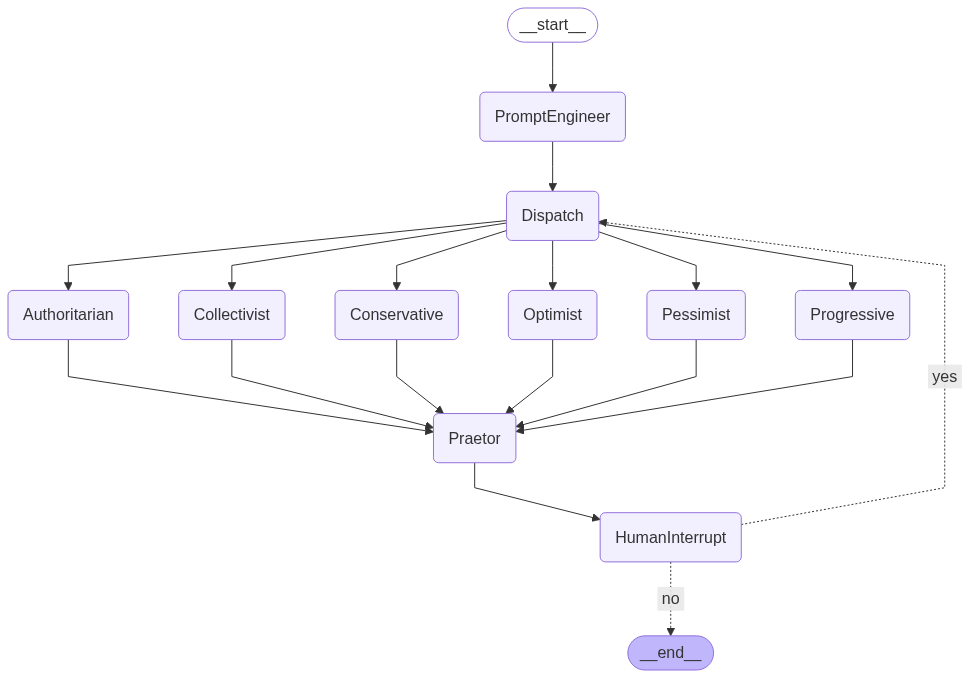

In [108]:
# Graph Visualization
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Visualization failed.")
    pass

In [109]:
# run the graph

initial_state = {
    "question": question,
    "loop_count": 1,
    "evaluations": [],          # list aggregator
    "praetor_outputs": {},      # dict merger
    "continue_": True,
    "role_prompts_rewrite": {}
}

state = initial_state
while state["continue_"]:
    print(f"\n===== Loop {state['loop_count']} =====")
    state = graph.invoke(state)
    # state["loop_count"] += 1      # this is moved to the human interrupt node


===== Loop 1 =====
Rewriting role prompts...
  - Optimist: Imagine a world brimming with potential! As a futurist focused on positive change, identify the technology poised to *improve* lives most dramatically by 2026. Focus on benefits, accessibility, and widespread adoption. What sparks joy and progress?
  - Pessimist: Assume things will likely go wrong. As a skeptical observer, pinpoint the technology trend of 2026 that will create the *most* problems – exacerbating inequalities, enabling misuse, or causing unforeseen negative consequences. What could backfire spectacularly?
  - Conservative: Tradition and stability matter. As a guardian of established values, consider which technology trend of 2026 will least disrupt existing societal structures and offer the most *reliable* improvements within a familiar framework. Prioritize proven concepts.
  - Progressive: Equity and social justice are paramount. As an advocate for change, identify the 2026 technology trend with the greatest p